# Test Training with ResNet50


# Load iNaturalist Training Dataset via API


To create our training data. We will be collecting 100 images for 5 chosen species as the classes we want to retrain the model with.  The code was originally developed by another member of the intern team, [Efe](https://github.com/TotaalyNOTefexD).

## Imports

In [1]:
import os
import requests
import pandas as pd
from PIL import Image
from io import BytesIO
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm import tqdm  # Progress bar

## Setup

In [2]:
# List of species names to search for
species_names =  ['Panthera leo', 'Falco peregrinus', 'Oryx gazella', 'Zalophus wollebaeki', 'Rattus rattus']

# Maximum number of images to download for each species
max_images_per_species = 100

In [3]:
# Function to download and resize image
def download_and_resize_image(url, save_dir, obs_id, max_size=(180, 180)):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        img = img.resize(max_size)  # Resize image to the exact specified size

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        # Save the image with a unique name based on the observation ID
        img_name = f"{obs_id}.jpg"
        img_path = os.path.join(save_dir, img_name)
        img.save(img_path)
        return img_path
    except Exception as e:
        return None

## Downloading images

In [4]:

session = requests.Session()
retry_strategy = Retry(
    total=3,
    status_forcelist=[429, 500, 502, 503, 504],
    backoff_factor=1
)
adapter = HTTPAdapter(max_retries=retry_strategy)
session.mount('https://', adapter)

for species_name in species_names:
    try:
        # Directory to save images for the current species, change as needed
        save_dir = f'/home/DataSet/{species_name.replace(" ", "_")}_images'

        # Fetch taxon ID for the current species name
        search_response = session.get(f'https://api.inaturalist.org/v1/taxa?q={species_name}&rank=species', timeout=10).json()
        if not search_response['results']:
            print(f"No taxon found for species: {species_name}")
            continue

        # Assume the first result is the desired species
        taxon_id = search_response['results'][0]['id']

        observation_ids = []
        image_urls = []
        common_names = []
        scientific_names = []

        valid_image_count = 0

        # Fetch observations for the current species until the desired number of images is reached
        page = 1
        while valid_image_count < max_images_per_species:
            observations_response = session.get(
                f'https://api.inaturalist.org/v1/observations?taxon_id={taxon_id}&per_page=200&page={page}', timeout=10
            ).json()
            observations = observations_response['results']

            if not observations:
                break

            for observation in tqdm(observations, desc=f'Processing observations for {species_name}'):
                if valid_image_count >= max_images_per_species:
                    break

                # Extract and store observation details
                obs_id = observation['id']
                taxon = observation.get('taxon')
                if taxon:
                    common_name = taxon.get('preferred_common_name', 'No common name available')
                    scientific_name = taxon.get('name', 'No scientific name available')
                else:
                    common_name = 'No common name available'
                    scientific_name = 'No scientific name available'

                # Extract and store image data
                if 'observation_photos' in observation and observation['observation_photos']:
                    photo = observation['observation_photos'][0]['photo']
                    image_url = photo['url']
                    image_path = download_and_resize_image(image_url, save_dir=save_dir, obs_id=obs_id)
                    if image_path:
                        observation_ids.append(obs_id)
                        common_names.append(common_name)
                        scientific_names.append(scientific_name)
                        image_urls.append(image_url)
                        valid_image_count += 1

            page += 1

        # Create a DataFrame with observation details for the current species
        data = {
            'Observation ID': observation_ids,
            'Common Name': common_names,
            'Scientific Name': scientific_names,
            'Image URL': image_urls,
            'Image Path': [os.path.join(save_dir, f"{obs_id}.jpg") for obs_id in observation_ids]
        }
        df = pd.DataFrame(data)

        # Cap the dataset size to match the number of images available
        if valid_image_count < max_images_per_species:
            df = df.head(valid_image_count)

        # Save to a CSV file for the current species, change as needed
        csv_path = f'/home/{species_name.replace(" ", "_")}_dataset.csv'
        df.to_csv(csv_path, index=False)

        print(f"Data saved to {csv_path} for species: {species_name}")

    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")

Processing observations for Panthera leo:  54%|█████▎    | 107/200 [00:27<00:23,  3.94it/s]


Data saved to /home/Panthera_leo_dataset.csv for species: Panthera leo


Processing observations for Falco peregrinus:  53%|█████▎    | 106/200 [00:18<00:16,  5.84it/s]


Data saved to /home/Falco_peregrinus_dataset.csv for species: Falco peregrinus


Processing observations for Oryx gazella:  50%|█████     | 101/200 [00:16<00:16,  6.17it/s]


Data saved to /home/Oryx_gazella_dataset.csv for species: Oryx gazella


Processing observations for Zalophus wollebaeki:  50%|█████     | 101/200 [00:18<00:17,  5.58it/s]


Data saved to /home/Zalophus_wollebaeki_dataset.csv for species: Zalophus wollebaeki


Processing observations for Rattus rattus:  50%|█████     | 101/200 [00:21<00:21,  4.63it/s]

Data saved to /home/Rattus_rattus_dataset.csv for species: Rattus rattus


In [5]:
# Count number of images downloaded
path = '/home/DataSet'
folders = os.listdir(path)
totalImages = 0
for folder in folders:
  images = os.listdir(f"{path}/{folder}")
  totalImages += len(images)

print(totalImages)

500


# Load iNaturalist Validation Dataset via inat competition 2021

##Imports

In [6]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Setup

In [7]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# Only load validation set
SPLIT = 'val'
SPLIT_FILE = SPLIT_FILENAMES[SPLIT]

# maps dataset to split tar & json files
splitDownloads = {}


##Download

In [8]:
# download image tar file
splitDownloads[f'{SPLIT}_img'] =  tfds.download.Resource(
          url=f'{URL}/{SPLIT_FILE}.tar.gz',
          extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
      )
# download json annotation file
splitDownloads[f'{SPLIT}_json'] = f'{URL}/{SPLIT_FILE}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)     # downloading the tar file containing validation images

{'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x784b2f7acb50>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

## Retrieving annotations from JSON file to load images from validation dataset


In [9]:
# paths to loaded dataset

imagesArchive = outputPaths[f'{SPLIT}_img']
jsonFile = os.path.join(outputPaths[f'{SPLIT}_json'],f'{SPLIT_FILE}.json')

In [10]:
with epath.Path(jsonFile).open('r') as f:
      inatJson = json.load(f)

In [11]:
def format(label: str):
      # replace ' ' with '_' in a string
      return label.lower().replace(' ', '_')

# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, image_id):

      if 'annotations' in inatJson:

        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == image_id

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Curating collection of annotated images

###Filtering

The code below allows us ensure that we only extract images related to vertebrates and our 5 selected species.

In [12]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [13]:
# List containing the animals that user want to see/train on
animalsToRetrieve = [format(name).lower() for name in species_names]      # formated so that images can be recognised
print(animalsToRetrieve)

['panthera_leo', 'falco_peregrinus', 'oryx_gazella', 'zalophus_wollebaeki', 'rattus_rattus']


###Map images to their annotations

In [14]:
annotatedFiles = {}   # stores specified annotation and metadata of species

for idx, image in enumerate(inatJson['images']):

  category, superCategory, imageDirectory = getAnnotation(idx, image['id'])
  if (superCategory in vertebrates) and (category in animalsToRetrieve):      # Checking if the species is a vertebrate and checking latin name of the animal (using category)
    field = os.path.basename(image['file_name']).split('.')[0]

    annotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [15]:
print(annotatedFiles)
print(len(annotatedFiles))


{'300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '68def9b7-2b36-4a03-800b-e13eea5b9f57': {'id': 2690192, 'file_id': '68def9b7-2b36-4a03-800b-e13eea5b9f57', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89': {'id': 2690373, 'file_id': 'b1acd7a9-9b88-4f90-a9ae-64cf3332ad89', 'label': 'rattus_rattus', 'superCategory': 'mammals', 'imagedirectory': '04815_Animalia_Chordata_Mammalia_Rodentia_Muridae_Rattus_rattus'}, '9ba73392-081b-4813-bc2f-11bf64bf8a7d': {'id': 2690706, 'file_id': '9ba73392-081b-4813-bc2f-11bf64bf8a7d', 'label': 'zalophus_wollebaeki', 'superCategory': 'mammals', 'imagedirectory': '04710_Animalia_Chordata_Mammalia_Carnivora_Otariidae_Zalophus_wollebaeki'

## Extracting the images

In [16]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  t.extractall('/home', members=imgToExtract)


#Resizing and renaming

In [17]:
from PIL import Image
import os,sys

# rename all folders to match class names of the training dataset
path = '/home/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      im = Image.open(item_path)
      f, e = os.path.splitext(item_path)
      imResize = im.resize((180,180))     # resizing image so that it can be read by the model
      imResize.save(item_path,'JPEG', quality=90)

# Building the Model

##Imports

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

##Quick check

In [19]:
import pathlib
data_dir = pathlib.Path('/home/DataSet').with_suffix('')      # directory that stores the training data

# image count
imageCount = len(list(data_dir.glob('*/*.jpg')))

## Preprocessing / Creating dataset

In [20]:
batch_size = 32
img_height = 180
img_width = 180

In [21]:
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 500 files belonging to 5 classes.


In [22]:
# Identifying class names that model has to train for. These the species the user selected to train on.
class_names = train_ds.class_names
print(class_names)

['Falco_peregrinus_images', 'Oryx_gazella_images', 'Panthera_leo_images', 'Rattus_rattus_images', 'Zalophus_wollebaeki_images']


In [23]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [24]:
# Creating the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/home/val',
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 50 files belonging to 5 classes.


## Configuring dataset for performance

In [25]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarise data

RGB channel values are in the range `[0,255]`. But this is not ideal for NN, so need to make input values small.

Use `tf.keras.layers.Rescaling` to standardise values to `[0,1]` range.

In [26]:
normalization_layer = layers.Rescaling(1./255)

## Creating the Model



In [27]:
from tensorflow.keras.applications import ResNet50

num_classes = len(class_names)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pretrained weights
resnet50_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(img_height, img_width, 3))
x = resnet50_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


#Compile the Model

Optimizer is `tf.keras.optimizers.Adam`\
Loss function is `tf.keras.losses.SparseCategoricalCrossEntropy`

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Training of Model

In [30]:
# using 10 epochs of size 32 and with model.fit method

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 70s 4s/step - loss: 1.4468 - accuracy: 0.4500 - val_loss: 0.8878 - val_accuracy: 0.6600
Epoch 2/10
16/16 [==============================] - 65s 4s/step - loss: 0.6982 - accuracy: 0.7400 - val_loss: 0.6810 - val_accuracy: 0.7600
Epoch 3/10
16/16 [==============================] - 72s 5s/step - loss: 0.4786 - accuracy: 0.8340 - val_loss: 0.6608 - val_accuracy: 0.7400
Epoch 4/10
16/16 [==============================] - 65s 4s/step - loss: 0.3828 - accuracy: 0.8880 - val_loss: 0.5969 - val_accuracy: 0.7600
Epoch 5/10
16/16 [==============================] - 69s 4s/step - loss: 0.3068 - accuracy: 0.9200 - val_loss: 0.6328 - val_accuracy: 0.7600
Epoch 6/10
16/16 [==============================] - 71s 5s/step - loss: 0.2586 - accuracy: 0.9320 - val_loss: 0.6510 - val_accuracy: 0.7200
Epoch 7/10
16/16 [==============================] - 64s 4s/step - loss: 0.2199 - accuracy: 0.9560 - val_loss: 0.6197 - val_accuracy: 0.7200
Epoch 8/10
16/16 [==

# Visualising training results

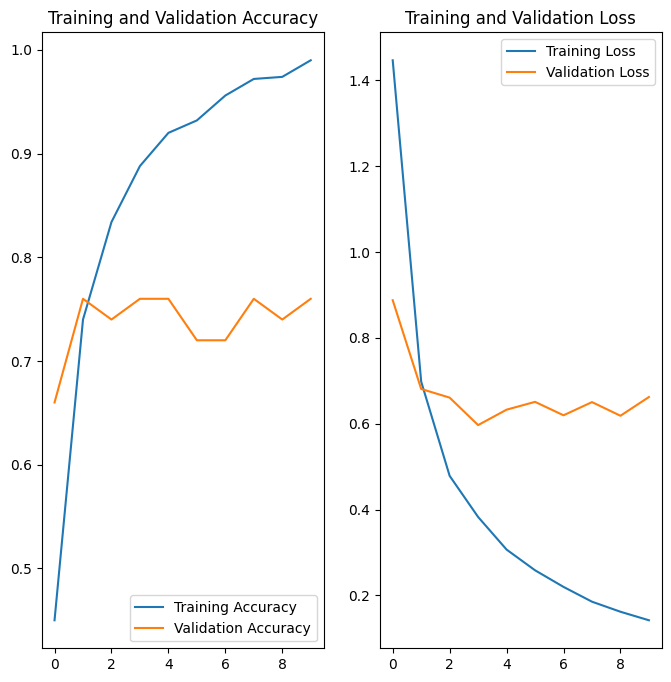

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Issues
# initial model finds:
As you can observe from the right hand graph, the graph indicates that it is overfitted as the validation loss is increases as the training loss decreases.

However, this could also be due to the fact that when the iNaturalist 2021 validation set images are downloaded and resized to 180x180. Which could leave images to be skewed awkwardly.


These overfitted results could be further magnified by the small training dataset.

But for now, let us experiment with usual methods of overfitting.

#new model findings:
Compared to the initial model, the validation loss doesnt increase as training loss decreases, after 3 epochs it grows more consistent.


# Attempting to deal with Overfitting

## Attempting to make our inputs better


Why are our input images bad and how could it affect our model performances?  The performance of the model is  affected by the fact that the validation images from the 2021k iNaturalist validation dataset had an aspect ratio of 2:3 which is then made to fit the 1:1 smaller input size, causing skew.

### Changing validation split images from 2:1 to 1:1 ratio images


In [32]:
from PIL import Image
import os,sys

In [33]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(imagesArchive, 'r')

except IOError as e:
  print(e)

else:

  for id,value in annotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"
    imgToExtract.append(imgFilePath)

  t.extractall('/home/val2.0', members=imgToExtract)      # download the new images to another folder


### Cropping the validation images

In [34]:
# rename all folders
path = '/home/val2.0/val'
dirs = os.listdir(path)

for folder in dirs:
  # rename folders so class folders match the names of the training dataset
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get new path to manipulate images
  new_path = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  image_dir = os.listdir(new_path)

  for item in image_dir:
    # full image path
    item_path = f"{new_path}/{item}"

    if os.path.isfile(item_path):
      print(f"Currently manipulating {item}")
      im = Image.open(item_path)

      # cropping the images to square aspect ratio
      width, height = im.size
      min_dimension = min(width, height)
      # left(x), upper(y), right(x), lower(y)
      img_mid_area = ((width - min_dimension) // 2,
                      (height - min_dimension) // 2,
                      ((width - min_dimension) // 2) + min_dimension,
                       ((height - min_dimension) // 2) + min_dimension)
      img_cropped = im.crop(img_mid_area)

      # resize square cropped images to 180x180px
      imResize = img_cropped.resize((180,180))

      imResize.save(item_path,'JPEG', quality=90)


Currently manipulating 47eef763-3a93-4316-8676-9820e2d41c25.jpg
Currently manipulating fe81176c-f896-4ff9-af53-602010fe6fd5.jpg
Currently manipulating 8a438be6-27f7-483d-9c38-9744c1cedf0b.jpg
Currently manipulating 8607ad90-ad48-4da5-b088-b9d7ab90d771.jpg
Currently manipulating 16007a46-1c4f-4e44-978b-f2f6f7042393.jpg
Currently manipulating 2e71b939-84b2-404a-ae33-adf3f49a1fdd.jpg
Currently manipulating e377fd75-d9dd-4381-8f13-f80b7b527cc2.jpg
Currently manipulating 9170a283-7d96-413d-aa69-6279de447174.jpg
Currently manipulating c244c16e-f456-483b-b1b7-53d15a381f54.jpg
Currently manipulating 17f0a6d0-755b-47c3-9fee-f881e3ab510b.jpg
Currently manipulating 5dcbbcf8-e1b8-400b-b834-5c1e86885cff.jpg
Currently manipulating 25b3ef16-2528-409f-ba37-0b4e0bb92d2d.jpg
Currently manipulating 83b87a73-0f1c-4bf0-9220-86d5789626d9.jpg
Currently manipulating b0f0d610-5aba-4df0-86ed-6594e43b567f.jpg
Currently manipulating ae9adbce-1809-4263-8737-020aee79e657.jpg
Currently manipulating bcbf1577-1003-410

## Dropout and Data augmentation

### Data augmentation

In [35]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

View augmented examples:

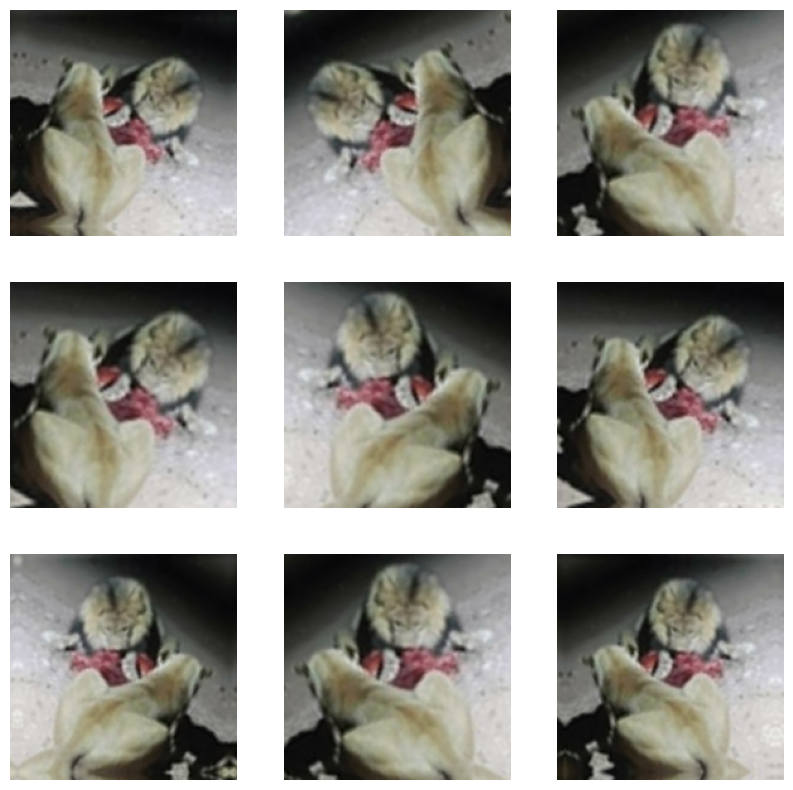

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

Applying dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value.

After applying dropout to a new neuralnetwork before training it using the augmented images:

In [37]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

### Compile and training the new tuned model

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [40]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 19s 1s/step - loss: 1.7688 - accuracy: 0.2480 - val_loss: 1.4744 - val_accuracy: 0.3600
Epoch 2/15
16/16 [==============================] - 17s 1s/step - loss: 1.4396 - accuracy: 0.3420 - val_loss: 1.2508 - val_accuracy: 0.5200
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 1.2954 - accuracy: 0.4720 - val_loss: 1.2176 - val_accuracy: 0.5000
Epoch 4/15
16/16 [==============================] - 18s 1s/step - loss: 1.2987 - accuracy: 0.4440 - val_loss: 1.1812 - val_accuracy: 0.4800
Epoch 5/15
16/16 [==============================] - 17s 1s/step - loss: 1.2366 - accuracy: 0.5020 - val_loss: 1.2445 - val_accuracy: 0.5000
Epoch 6/15
16/16 [==============================] - 19s 1s/step - loss: 1.1590 - accuracy: 0.5280 - val_loss: 1.2784 - val_accuracy: 0.5200
Epoch 7/15
16/16 [==============================] - 17s 1s/step - loss: 1.1518 - accuracy: 0.5420 - val_loss: 1.1687 - val_accuracy: 0.5400
Epoch 8/15
16/16 [==

## Visualise training results

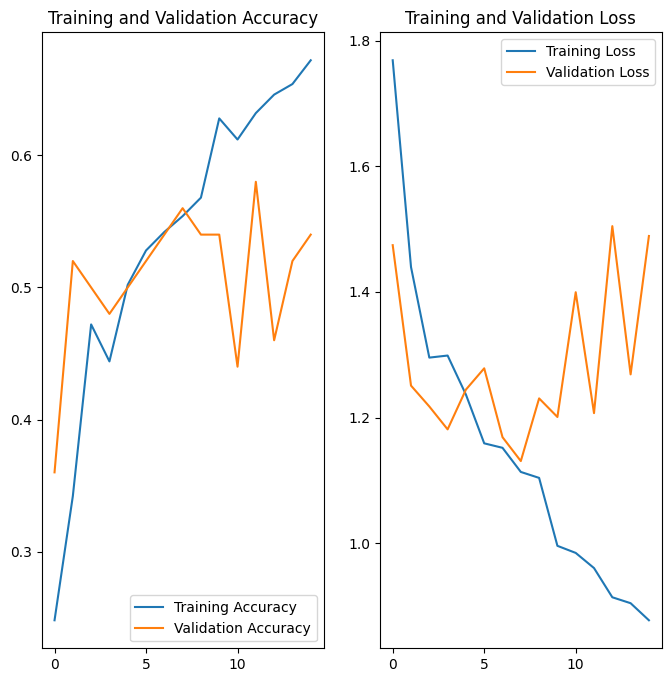

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can observe from the right-hand graph the the validation loss has actually grown more inconsistent, even increasing slighly more compared to our first model(that Avis made).Showing that the validation loss begins rapidly increases after 10 epochs. This perhaps indicates that the optimum epoch parameter could be from 8-10.